In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
ames = pd.read_csv("/content/AmesHousing.csv")
# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()
ames

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,8885,Pave,IR1,Low,AllPub,Inside,...,0,0,0,0,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,4,2006,WD,Normal,170000


## 14.1: Check-In Questions + Initial Code

In [10]:
X = ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = ames["SalePrice"]

ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)


**Check In Question 1:** What did `handle_unknown='ignore'` accomplish?

`handle_unknown='ignore'` tells OneHotEncoder to ignore categories in test and validation data not part of the training data, preventing errors during cross validation when new categories appear.

**Check In Question 2:** What did `make_column_selector(dtype_include=object)` accomplish?

`make_column_selector(dtype_include=object)` selects all object (categorical) columns for one-hot encoding. This makes the pipeline more flexible and less prone to errors than manually listing column names.

**Check-In Question 3:** Why did we drop the `Order` and `PID` columns?

`Order` and `PID` are identifiers with no predictive relationship to house prices. By including them, it would add noise and could potentially cause overfitting.

In [11]:
OLS_Scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
print("OLS Cross Validation R Squared scores:", OLS_Scores)
print(f"Mean: {OLS_Scores.mean():.4f}")

OLS Cross Validation R Squared scores: [0.89727873 0.91038253 0.78900365 0.77208628 0.9006982 ]
Mean: 0.8539


In [14]:
lr_pipeline.fit(X, y)
OLS_coefs = lr_pipeline.named_steps['linear_regression'].coef_; OLS_coefs

array([-4.64855496e+03,  1.54668800e+03, -7.51605192e+03,  7.86744223e+03,
        3.77444054e+03, -1.02396389e+03, -1.04668856e+04,  1.04668856e+04,
       -2.49190887e+03,  3.71457104e+03, -1.69659499e+02, -1.05300267e+03,
       -5.36701724e+03,  9.08725534e+03, -7.47662459e+03,  3.75638649e+03,
        1.16561643e+04, -8.57228347e+03, -3.08388080e+03,  1.18143694e+03,
        7.34156698e+03, -5.18301350e+03, -4.18616309e+03,  8.46172657e+02,
        3.34875241e+03,  1.00949506e+04, -1.34437030e+04, -3.76532588e+03,
        3.01395902e+03,  6.12156044e+03, -6.79264123e+03, -1.22730485e+04,
       -1.43722801e+04,  3.67252628e+03, -2.17147395e+04, -1.53104590e+04,
        4.75907318e+03,  1.27054305e+05, -1.31972465e+04, -5.80178043e+03,
        9.89074009e+01, -1.81546821e+04, -1.81987406e+04,  1.18041208e+04,
       -2.13469597e+04,  2.30734383e+04,  1.73231985e+04, -1.72199252e+04,
       -1.53455595e+04, -1.38533211e+04, -1.53571916e+04,  8.08424189e+03,
        3.50940314e+04, -

## 14.2: Ridge Regression with λ = 1

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with λ = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

Ridge CV R-squared scores: [0.89815807 0.91744024 0.79493606 0.78522563 0.91389818]
Mean: 0.8619

OLS Mean: 0.8539
Ridge Mean: 0.8619


<Axes: xlabel='ols', ylabel='ridge'>

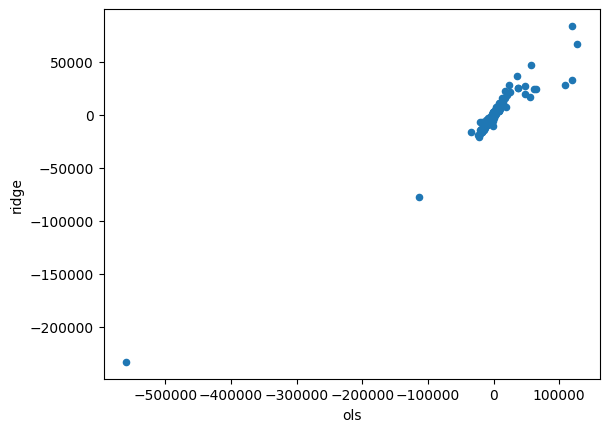

In [30]:
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

ridgescore = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')

print("Ridge CV R-squared scores:", ridgescore)
print(f"Mean: {ridgescore.mean():.4f}")
print(f"\nOLS Mean: {OLS_Scores.mean():.4f}")
print(f"Ridge Mean: {ridgescore.mean():.4f}")

ridge_pipeline_fitted = ridge_pipeline.fit(X, y);ridge_pipeline_fitted

ridge_coefs = ridge_pipeline_fitted.named_steps['ridge_regression'].coef_

comparecoef = pd.DataFrame()
comparecoef["ols"] = OLS_coefs
comparecoef["ridge"] = ridge_coefs

comparecoef.plot.scatter(x='ols', y='ridge')

## 14.2.1: Using the same pipeline as previously, perform tuning on λ

You should always try
 values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

Best λ: 10
Best Cross validation R squared: 0.8643


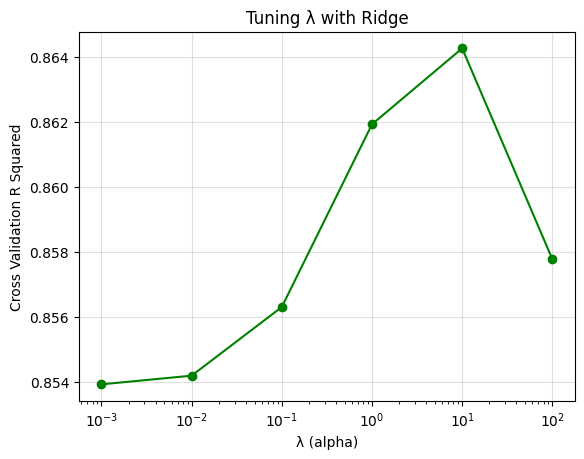

In [24]:
ridge_tune = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge())]
)

param_grid = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_tune, param_grid, cv=5, scoring='r2')
ridge_grid.fit(X, y)

print(f"Best λ: {ridge_grid.best_params_['ridge_regression__alpha']}")
print(f"Best Cross validation R squared: {ridge_grid.best_score_:.4f}")

ridgeresults = pd.DataFrame(ridge_grid.cv_results_)

plt.semilogx(ridgeresults['param_ridge_regression__alpha'], ridgeresults['mean_test_score'], 'go-')
plt.xlabel('λ (alpha)')
plt.ylabel('Cross Validation R Squared')
plt.title('Tuning λ with Ridge')
plt.grid(True, alpha=0.4)
plt.show()

## 14.3.1: LASSO Regression

Create a LASSO pipeline, and tune λ.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [27]:
tunedlasso = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)

param_grid = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lassogrid = GridSearchCV(tunedlasso, param_grid, cv=5, scoring='r2')
lassogrid.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7db2f75c7cb0>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7db2f75c31d0>)])),
                                       ('lasso_regression', Lasso())]),
             param_grid={'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                     100]},
             scoring='r2')

In [28]:
print(f"Best λ: {lassogrid.best_params_['lasso_regression__alpha']}")
print(f"Best Cross Validation R squared: {lassogrid.best_score_:.4f}")

Best λ: 100
Best Cross Validation R squared: 0.8669


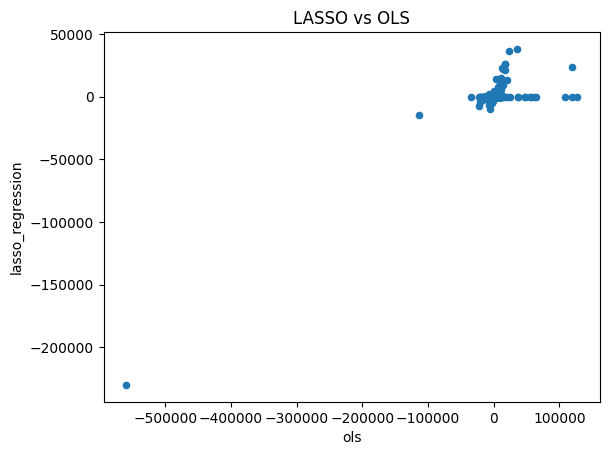

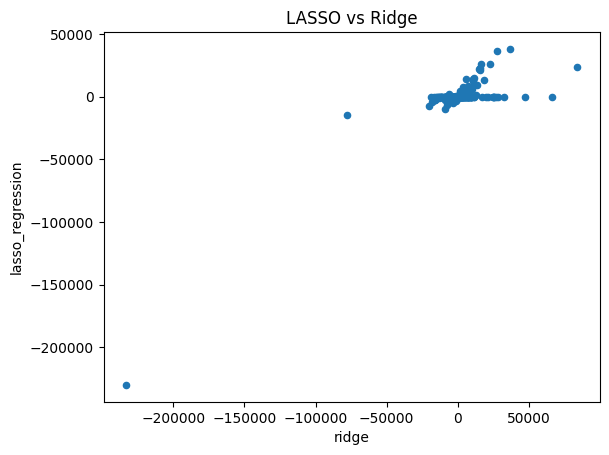

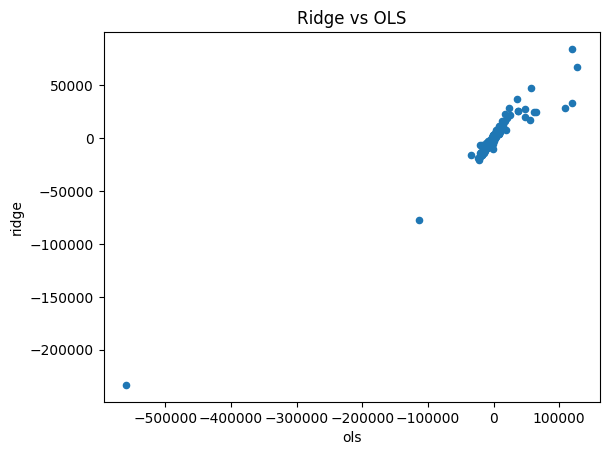

In [35]:
coef_lasso = lassogrid.best_estimator_.named_steps['lasso_regression'].coef_
bestridge = ridge_grid.best_estimator_.named_steps['ridge_regression'].coef_

comparecoef["lasso_regression"] = coef_lasso

#LASSO vs OLS
comparecoef.plot.scatter(x='ols', y='lasso_regression', title='LASSO vs OLS');plt.show()

#LASSO vs Ridge
comparecoef.plot.scatter(x='ridge', y='lasso_regression', title='LASSO vs Ridge');plt.show()

#Ridge vs OLS
comparecoef.plot.scatter(x='ols', y='ridge', title='Ridge vs OLS');plt.show()

## 14.3.3: Elastic Net

Create an Elastic Net pipeline, and tune
λ and α.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.



In [36]:
tunedelastic = Pipeline(
    [("preprocessing", ct),
     ("elastic_regression", ElasticNet())]
)

param_grid = {
    'elastic_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic_regression__l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
}
elasticgrid = GridSearchCV(tunedelastic, param_grid, cv=5, scoring='r2')
elasticgrid.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('dummify',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7db2f75c7cb0>),
                                                                        ('standardize',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7db2f75c31d0>)])),
                                       ('elastic_regression', ElasticNet())]),
             param_grid={'elastic_regression__alpha': [0.001, 0.01, 0.1, 1, 10,
                                                       100],
                         'elastic_regression__l1_ratio': [0.0, 0.2, 0.4, 0.6,
                                                          0.8, 1.0]},
             scoring='r2')

In [37]:
print(f"Best λ: {elasticgrid.best_params_['elastic_regression__alpha']}")
print(f"Best α (l1_ratio): {elasticgrid.best_params_['elastic_regression__l1_ratio']}")
print(f"Best Cross Validation R Squared: {elasticgrid.best_score_:.4f}")

Best λ: 100
Best α (l1_ratio): 1.0
Best Cross Validation R Squared: 0.8669


In [39]:
elastic_coefs = elasticgrid.best_estimator_.named_steps['elastic_regression'].coef_

print("\nFinal Comparisons:")
print(f"{'Model':<25} {'Cross Validation R squared':<15} {'Zero Coefficients':<10}")
print("="*50)
print(f"{'OLS':<25} {OLS_Scores.mean():<15.4f} {(OLS_coefs == 0).sum():<10}")
print(f"{'Ridge':<25} {ridge_grid.best_score_:<15.4f} {(bestridge == 0).sum():<10}")
print(f"{'Lasso':<25} {lassogrid.best_score_:<15.4f} {(coef_lasso == 0).sum():<10}")
print(f"{'Elastic Net':<25} {elasticgrid.best_score_:<15.4f} {(elastic_coefs == 0).sum():<10}")


Final Comparisons:
Model                     Cross Validation R squared Zero Coefficients
OLS                       0.8539          0         
Ridge                     0.8643          0         
Lasso                     0.8669          163       
Elastic Net               0.8669          163       
